In [1]:
!pip install --upgrade tensorflow
!pip install -U Keras
!pip install seaborn

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.1)
Requirement already up-to-date: Keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


##All the Imports

In [2]:
import re
import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models.wrappers import FastText

import numpy as np
from tqdm import tqdm

from keras import backend as K
from keras import initializers, regularizers, constraints
#from keras.layers.core import Layer
from keras.layers import Layer
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional, Embedding, GRU, Flatten, Input
from keras.optimizers import Adam, SGD
from keras.models import Model

from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics

from sklearn.dummy import DummyClassifier

from sklearn.utils import resample

##Download Embedings

In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gzip -d cc.en.300.bin.gz

--2021-02-15 08:08:30--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  52.2MB/s    in 80s     

2021-02-15 08:09:50 (53.9 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [4]:
fasttext = FastText.load_fasttext_format('cc.en.300.bin')

##Load Dataset

In [5]:
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df
  
logging.set_verbosity(logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

84131840/84125825 [==============================] - 2s 0us/step


,sentence,sentiment,polarity
0,"Talk about a blast opening, ""Trampa Infernal"" ...",7,1
1,"I really wanted to like this film, but so much...",3,0
2,Extremely well-conceived - part whatever happe...,9,1
3,Caught this film in about 1990 on video by cha...,10,1
4,"Soylent Green IS...a really good movie, actual...",10,1


Processing Dataset

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [7]:
train_df['Processed_Reviews'] = train_df.sentence.apply(lambda x: clean_text(x))
test_df['Processed_Reviews'] = test_df.sentence.apply(lambda x: clean_text(x))

In [8]:
Reviews_train=train_df['Processed_Reviews'].to_numpy()
Labels_train=train_df['polarity'].to_numpy()
Reviews_test=test_df['Processed_Reviews'].to_numpy()
Labels_test=test_df['polarity'].to_numpy()

Split the Dataset into Train, Test and Validation Sets

In [9]:
Reviews_val, Reviews_test, Labels_val, Labels_test = train_test_split(Reviews_test, Labels_test, test_size=0.4, random_state=1)

In [10]:
print("Train Data =",len(Reviews_train),len(Labels_train))
print("Test Data =",len(Reviews_test),len(Labels_test))
print("Validation Data =",len(Reviews_val),len(Labels_val))

Train Data = 25000 25000
Test Data = 10000 10000
Validation Data = 15000 15000


The average for max_length

In [11]:
print(train_df.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean())

129.47972


In [12]:
vocab = 10000 + 1
max_length = 130

tokenizer = Tokenizer(num_words=vocab, oov_token='__UNK__')
tokenizer.fit_on_texts(Reviews_train)

Reviews_train_seqs = tokenizer.texts_to_sequences(Reviews_train)
Reviews_val_seqs = tokenizer.texts_to_sequences(Reviews_val)
Reviews_test_seqs = tokenizer.texts_to_sequences(Reviews_test)

Reviews_train = pad_sequences(Reviews_train_seqs, maxlen=max_length,padding='post')
Reviews_val = pad_sequences(Reviews_val_seqs, maxlen=max_length, padding='post')
Reviews_test = pad_sequences(Reviews_test_seqs, maxlen=max_length, padding='post')

In [13]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 103446 unique tokens.


In [14]:
vocab_words = list(word_index.keys())[:10000]

embedding_dim = fasttext.vector_size

embedding_matrix = np.zeros((vocab, embedding_dim))

for word in tqdm(vocab_words):
  try:
    index = word_index[word]
    embedding_matrix[index] = fasttext[word]
  except:
    pass

100%|██████████| 10000/10000 [00:00<00:00, 174668.05it/s]


In [15]:
np.save("embedding_matrix.npy", embedding_matrix, allow_pickle=True)

In [16]:
def dot_product(x, kernel):
  
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class DeepAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, u_regularizer=None, bias_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b1_regularizer = regularizers.get(bias_regularizer)
        self.b2_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b1_constraint = constraints.get(b_constraint)
        self.b2_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        

        if self.bias:
            self.b1 = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b1'.format(self.name),
                                     regularizer=self.b1_regularizer,
                                     constraint=self.b1_constraint)
            self.b2 = self.add_weight(shape=(1,),
                                     initializer='zero',
                                     name='{}_b2'.format(self.name),
                                     regularizer=self.b2_regularizer,
                                     constraint=self.b2_constraint)
        else:
            self.b1 = None
            self.b2 = None

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        self.built = True


    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        # uit = tanh(Wx + b)
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b1

        uit = K.tanh(uit)

        # ait = softmax(Ueij)
        eij = dot_product(uit, self.u)
        if self.bias:
            eij += self.b2

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        a = K.expand_dims(K.softmax(eij, axis=-1))
        
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

# RNN Model with Deep Attention

In [17]:
GRU_SIZE = 100
DENSE = 200
N_CLASSES = 1

inputs = Input((max_length,))
embeddings = Embedding(vocab,embedding_dim, weights=[embedding_matrix], 
             input_length=max_length, mask_zero=True, trainable=True)(inputs)
dropout = Dropout(0.5)(embeddings)
bidirectional = Bidirectional(GRU(units=GRU_SIZE, return_sequences=True,recurrent_dropout = 0.2))(dropout)
bidirectional = Bidirectional(GRU(units=GRU_SIZE, return_sequences=True,recurrent_dropout = 0.2))(bidirectional)
x, attn = DeepAttention(return_attention=True)(bidirectional)
out = Dense(units=DENSE, activation="relu")(x) 
out = Dense(units=N_CLASSES, activation="sigmoid")(out)
modelRNN = Model(inputs, out)
adam = Adam(lr=0.0001, decay=1e-6)

print(modelRNN.summary())
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
modelRNN.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=["accuracy"])

checkpoint = ModelCheckpoint('keras_BiGRU_model.hdf6', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 130, 300)          3000300   
_________________________________________________________________
dropout (Dropout)            (None, 130, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 130, 200)          241200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 130, 200)          181200    
_________________________________________________________________
deep_attention (DeepAttentio [(None, 200), (None, 130, 40401     
_________________________________________________________________
dense (Dense)                (None, 200)               40200 

Fit the RNN Deep Attention Model

In [18]:
history = modelRNN.fit(Reviews_train,Labels_train,
                       batch_size=500,
                       epochs=15,
                       verbose = 1,
                       callbacks=[checkpoint, early_stopping],
                       validation_data=(Reviews_val, Labels_val))

Epoch 1/15
50/50 [==============================] - 42s 684ms/step - loss: 0.6890 - accuracy: 0.5202 - val_loss: 0.6605 - val_accuracy: 0.7104

Epoch 00001: val_loss improved from inf to 0.66054, saving model to keras_BiGRU_model.hdf6
INFO:tensorflow:Assets written to: keras_BiGRU_model.hdf6/assets
Epoch 2/15
50/50 [==============================] - 33s 668ms/step - loss: 0.6194 - accuracy: 0.7292 - val_loss: 0.4390 - val_accuracy: 0.8028

Epoch 00002: val_loss improved from 0.66054 to 0.43896, saving model to keras_BiGRU_model.hdf6
INFO:tensorflow:Assets written to: keras_BiGRU_model.hdf6/assets
Epoch 3/15
50/50 [==============================] - 33s 654ms/step - loss: 0.4128 - accuracy: 0.8150 - val_loss: 0.3564 - val_accuracy: 0.8447

Epoch 00003: val_loss improved from 0.43896 to 0.35643, saving model to keras_BiGRU_model.hdf6
INFO:tensorflow:Assets written to: keras_BiGRU_model.hdf6/assets
Epoch 4/15
50/50 [==============================] - 33s 656ms/step - loss: 0.3419 - accuracy

In [19]:
print("Evaluating... ")
print('Training data:', flush=True)
loss, acc = modelRNN.evaluate(Reviews_train, Labels_train, verbose=1)
print("  Train: loss %.3f - acc %.3f" % (loss, acc))
print('Cross-validation data:', flush=True)
loss, acc = modelRNN.evaluate(Reviews_val, Labels_val, verbose=1)
print("  Cross-val: loss %.3f - acc %.3f" % (loss, acc))
print('Test data:', flush=True)
loss, acc = modelRNN.evaluate(Reviews_test, Labels_test, verbose=1)
print("  Test: loss %.3f - acc %.3f" % (loss, acc))

Evaluating... 
Training data:
782/782 [==============================] - 98s 124ms/step - loss: 0.1852 - accuracy: 0.9324
  Train: loss 0.185 - acc 0.932
Cross-validation data:
469/469 [==============================] - 59s 125ms/step - loss: 0.2988 - accuracy: 0.8767
  Cross-val: loss 0.299 - acc 0.877
Test data:
313/313 [==============================] - 39s 125ms/step - loss: 0.3051 - accuracy: 0.8756
  Test: loss 0.305 - acc 0.876


Visualize Model Training History

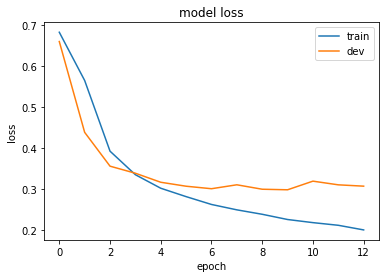

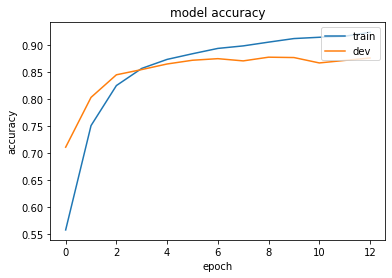

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

## Final Evaluate Performance on Train, Validation and Test 


In [21]:
Reviews_train_prob = modelRNN.predict(Reviews_train, batch_size=32, verbose=0)
Reviews_val_prob = modelRNN.predict(Reviews_val, batch_size=32, verbose=0)
Reviews_test_prob = modelRNN.predict(Reviews_test, batch_size=32, verbose=0)

print(metrics.classification_report(Labels_train, (Reviews_train_prob > 0.5).astype('int32')))
print(metrics.classification_report(Labels_val, (Reviews_val_prob > 0.5).astype('int32')))
print(metrics.classification_report(Labels_test, (Reviews_test_prob > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     12500
           1       0.93      0.94      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      7535
           1       0.88      0.87      0.88      7465

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4965
           1       0.88      0.87      0.88      5035

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Baseline classifier

In [22]:
modelBase = DummyClassifier(strategy='most_frequent')

Fit Baseline Model

In [23]:
modelBase.fit(Reviews_train, Labels_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

Evaluate Performance of Baseline

In [24]:
Reviews_train_prob = modelBase.predict(Reviews_train)
Reviews_val_prob = modelBase.predict(Reviews_val)
Reviews_test_prob = modelBase.predict(Reviews_test)

print(metrics.classification_report(Labels_train, (Reviews_train_prob > 0.5).astype('int32')))
print(metrics.classification_report(Labels_val, (Reviews_val_prob > 0.5).astype('int32')))
print(metrics.classification_report(Labels_test, (Reviews_test_prob > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     12500
           1       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      7535
           1       0.00      0.00      0.00      7465

    accuracy                           0.50     15000
   macro avg       0.25      0.50      0.33     15000
weighted avg       0.25      0.50      0.34     15000

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4965
           1       0.00      0.00      0.00      5035

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



## MLP Sequential model: a linear stack of layers

In [25]:
n_classes = 1

modelMLP = Sequential()
modelMLP.add(Embedding(vocab, embedding_dim, weights=[embedding_matrix], 
             input_length=max_length,mask_zero=False, trainable=True))
modelMLP.add(Flatten())
modelMLP.add(Dense(256, activation='relu'))
modelMLP.add(Dropout(0.5))
modelMLP.add(Dense(n_classes, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

modelMLP.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=["accuracy"])

checkpoint = ModelCheckpoint('keras_tf_idf_modelMLP.hdf5', monitor='val_f1', 
                             verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Fit MLP Model

In [26]:
historyMLP = modelMLP.fit(Reviews_train, Labels_train,
                       batch_size=64,
                       epochs=10,
                       verbose=1,
                       callbacks=[checkpoint, early_stopping],
                       validation_data=(Reviews_val, Labels_val))

Epoch 1/10
391/391 [==============================] - 6s 15ms/step - loss: 0.6621 - accuracy: 0.5917 - val_loss: 0.5355 - val_accuracy: 0.7371
Epoch 2/10
391/391 [==============================] - 4s 11ms/step - loss: 0.4461 - accuracy: 0.7997 - val_loss: 0.4499 - val_accuracy: 0.7831
Epoch 3/10
391/391 [==============================] - 4s 11ms/step - loss: 0.3148 - accuracy: 0.8661 - val_loss: 0.4468 - val_accuracy: 0.7937
Epoch 4/10
391/391 [==============================] - 4s 11ms/step - loss: 0.2246 - accuracy: 0.9139 - val_loss: 0.4687 - val_accuracy: 0.7914
Epoch 5/10
391/391 [==============================] - 4s 11ms/step - loss: 0.1522 - accuracy: 0.9482 - val_loss: 0.5145 - val_accuracy: 0.7902
Epoch 6/10
391/391 [==============================] - 4s 11ms/step - loss: 0.1033 - accuracy: 0.9675 - val_loss: 0.4645 - val_accuracy: 0.8164


Evaluate Performance of MLP

In [27]:
Reviews_train_prob = modelMLP.predict(Reviews_train, batch_size=32, verbose=0)
Reviews_val_prob = modelMLP.predict(Reviews_val, batch_size=32, verbose=0)
Reviews_test_prob = modelMLP.predict(Reviews_test, batch_size=32, verbose=0)

print(metrics.classification_report(Labels_train, (Reviews_train_prob > 0.5).astype('int32')))
print(metrics.classification_report(Labels_val, (Reviews_val_prob > 0.5).astype('int32')))
print(metrics.classification_report(Labels_test, (Reviews_test_prob > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93     12500
           1       0.96      0.88      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.93      0.92      0.92     25000
weighted avg       0.93      0.92      0.92     25000

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      7535
           1       0.84      0.73      0.78      7465

    accuracy                           0.79     15000
   macro avg       0.80      0.79      0.79     15000
weighted avg       0.80      0.79      0.79     15000

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      4965
           1       0.84      0.73      0.78      5035

    accuracy                           0.79     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.80      0.79      0.79     10000



##Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

modelLogistic = LogisticRegression(solver="liblinear",C=0.9)

Fit Logistic Regration Model

In [29]:
modelLogistic.fit(Reviews_train,Labels_train)

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Evaluate Performance of Logistic

In [30]:
Reviews_train_prob = modelLogistic.predict(Reviews_train)
Reviews_val_prob = modelLogistic.predict(Reviews_val)
Reviews_test_prob = modelLogistic.predict(Reviews_test)

print(metrics.classification_report(Labels_train, (Reviews_train_prob > 0.5).astype('int32')))
print(metrics.classification_report(Labels_val, (Reviews_val_prob > 0.5).astype('int32')))
print(metrics.classification_report(Labels_test, (Reviews_test_prob > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.54      0.59      0.56     12500
           1       0.54      0.49      0.52     12500

    accuracy                           0.54     25000
   macro avg       0.54      0.54      0.54     25000
weighted avg       0.54      0.54      0.54     25000

              precision    recall  f1-score   support

           0       0.52      0.60      0.55      7535
           1       0.52      0.44      0.48      7465

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.52     15000
weighted avg       0.52      0.52      0.52     15000

              precision    recall  f1-score   support

           0       0.50      0.59      0.54      4965
           1       0.51      0.43      0.47      5035

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.50     10000
weighted avg       0.51      0.51      0.50     10000



# BootStrap

In [31]:
def BootStrap(Reviews_test=Reviews_test,Labels_test=Labels_test,b=20,model=None):

  predictions_modelRNN = modelRNN.predict(Reviews_test)
  predictions_model = model.predict(Reviews_test)

  f1_modelRNN = f1_score(Labels_test,(predictions_modelRNN>0.5),average='macro')
  f1_model = f1_score(Labels_test,(predictions_model>0.5),average='macro')

  delta = f1_modelRNN - f1_model
  s=0
  for _ in range(b):

    Reviews_test, Labels_test = resample(Reviews_test,Labels_test)
    
    predictions_modelRNN = modelRNN.predict(Reviews_test)
    predictions_model = model.predict(Reviews_test)

    f1_modelRNN = f1_score(Labels_test,(predictions_modelRNN>0.5),average='macro')
    f1_model = f1_score(Labels_test,(predictions_model>0.5),average='macro')

    delta_star = f1_modelRNN - f1_model 

    if delta_star > 2*delta:
      s+=1

  return round(s/b,4)

RNN vs Baseline (Statistically Significant)

In [32]:
pvalue = BootStrap(model=modelBase)

print(pvalue)

0.0


RNN vs MLP (Statistically Significant)

In [33]:
pvalue = BootStrap(model=modelMLP)

print(pvalue)

0.0


RNN vs Logistic Regrassion (Statistically Significant)

In [34]:
pvalue = BootStrap(model=modelLogistic)

print(pvalue)

0.0


##ROC Curves

In [35]:
def plot_roc_curve(fpr,tpr):
  plt.plot(fpr,tpr)
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()

AUC score for RNN: 0.944703


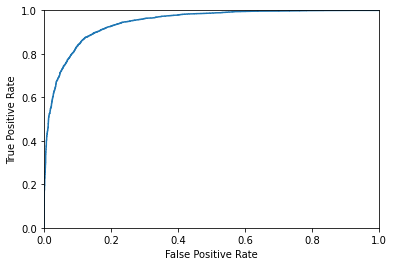

AUC score for Baseline: 0.500000


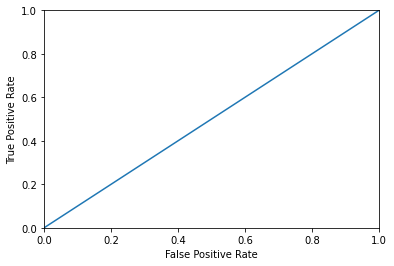

AUC score for MLP: 0.888238


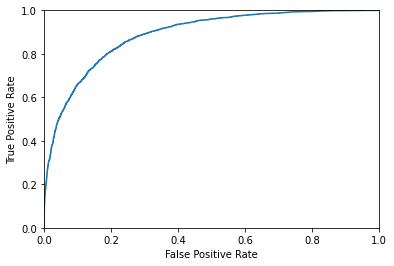

AUC score for Logistic Regression: 0.506849


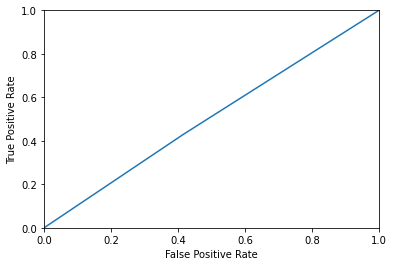

In [36]:
from sklearn.metrics import roc_curve,roc_auc_score
#------------For RNN Model---------------
Reviews_test_prob = modelRNN.predict(Reviews_test)
fpr , tpr , thresholds = roc_curve(Labels_test, Reviews_test_prob)
auc = roc_auc_score(Labels_test, Reviews_test_prob)
print('AUC score for RNN: %f' % auc)
plot_roc_curve(fpr,tpr)
#----------For Baseline Model---------
Reviews_test_prob = modelBase.predict(Reviews_test)
fpr , tpr , thresholds = roc_curve(Labels_test, Reviews_test_prob)
auc = roc_auc_score(Labels_test, Reviews_test_prob)
print('AUC score for Baseline: %f' % auc)
plot_roc_curve(fpr,tpr)
#------------For MLP Model---------------
Reviews_test_prob = modelMLP.predict(Reviews_test)
fpr , tpr , thresholds = roc_curve(Labels_test, Reviews_test_prob)
auc = roc_auc_score(Labels_test, Reviews_test_prob)
print('AUC score for MLP: %f' % auc)
plot_roc_curve(fpr,tpr)
#------------For Logistic Regression Model---------------
Reviews_test_prob = modelLogistic.predict(Reviews_test)
fpr , tpr , thresholds = roc_curve(Labels_test, Reviews_test_prob)
auc = roc_auc_score(Labels_test, Reviews_test_prob)
print('AUC score for Logistic Regression: %f' % auc)
plot_roc_curve(fpr,tpr)
